# Chemical Kinetics

> Find Steady State and time dependent concentrations of species

In [ ]:
#| default_exp kinetics

In [ ]:
#| export
#| echo: false
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [ ]:
#| export
def steady_state_calc(rates):
    """
    Calculate the steady state equilibrium of reaction a<->b<->c, given the rate of the forwards and backwards processes at each step
    """
    kf1 = rates[0]
    kr1 = rates[1]
    kf2 = rates[2]
    kr2 = rates[3]
    mat = np.array([[-kf1,kr1,0],[0,kf2,-kr2],[1,1,1]])
    vec = np.array([0,0,1])
    mat_inv = np.linalg.inv(mat)
    out = np.matmul(mat_inv, vec)
    return out

For instance, for varying concentrations of urea:

Consider the reaction

$$D  \xrightleftharpoons[k_{u}^{R15}]{k_{f}^{R15}}  I  \xrightleftharpoons[k_{u}^{R16}]{k_{f}^{R16}} N$$

In the steady state, the rate of change of all components it null and so

$$k_{u}^{R15}[I]-k_{f}^{R15}[D]=0$$
$$k_{f}^{R16}[I]-k_{u}^{R16}[N]=0$$

and with an additional restriction that the total number of substances is constant: wlg let that be 1:

$$[D]+[I]+[N]=1$$

As such this can be represented as a matrix:

$$\begin{pmatrix}-k_{f}^{R15}&k_{u}^{R15}&0\\ 0 & k_{f}^{R16} & -k_{u}^{R16}\\ 1&1&1\end{pmatrix}\begin{pmatrix} [D] \\ [I] \\ [N] \end{pmatrix} = \begin{pmatrix} 0 \\ 0 \\ 1 \end{pmatrix}$$

And thus

$$\begin{pmatrix} [D] \\ [I] \\ [N] \end{pmatrix} = \frac{1}{k_{f}^{R15}k_{f}^{R16}+k_{f}^{R15}k_{u}^{R16}+k_{u}^{R15}k_{u}^{R16}}\begin{pmatrix}-k_{f}^{R16}-k_{u}^{R16}&k_{u}^{R15}&k_{u}^{R15}k_{u}^{R16}\\ k_{u}^{R16} & k_{f}^{R15} & k_{f}^{R15}k_{u}^{R16}\\ k_{f}^{R16}&-k_{f}^{R15}-k_{u}^{R15}&k_{f}^{R15}k_{f}^{R16}\end{pmatrix}\begin{pmatrix} 0 \\ 0 \\ 1 \end{pmatrix}$$

In [ ]:
kf1 = 26000
kr1 = 0.06
kf2 = 730
kr2 = 0.00075
urea_conc = np.linspace(0, 8, num=1000)
ss_conc = []
for conc in urea_conc:
    rates = [kf1*np.exp(-1.68*conc), kr1*np.exp(0.95*conc), kf2*np.exp(-1.72*conc), kr2*np.exp(1.20*conc)]
    ss_conc.append(steady_state_calc(rates))


In [ ]:
ss_conc = np.array(ss_conc)

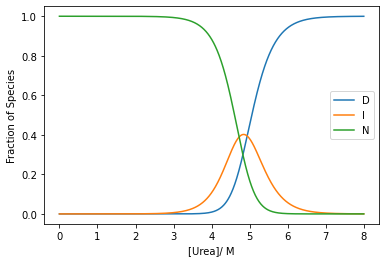

In [ ]:
plt.plot(urea_conc,ss_conc[:, 0],label='D')
plt.plot(urea_conc,ss_conc[:, 1],label='I')
plt.plot(urea_conc,ss_conc[:, 2],label='N')
plt.xlabel('[Urea]/ M')
plt.ylabel('Fraction of Species')
plt.legend()
plt.show()

In [ ]:
#| export
def _deriv(t, concs, k1, k2, k3, k4, k5):
    """
    Returns the time derivatives of concs = A, B, X, Y, Z, P, Q
    """
    A, B, X, Y, Z, P, Q = concs
    Adot = -A*Y*k1
    Bdot = -B*X*k3
    Xdot =A*Y*k1-X*Y*k2+B*X*k3-2*X*X*k4
    Ydot = -A*Y*k1-X*Y*k2 + Z*k5
    Zdot = B*X*k3 - Z*k5
    Pdot = A*Y*k1 + X*Y*k2
    Qdot = X*X*k4
    return Adot, Bdot, Xdot, Ydot, Zdot, Pdot, Qdot

In [ ]:
#| export
def oreg_calc_radau(concs, rates={'k1':1.34, 'k2':1.6e9, 'k3':8e3, 'k4':4e7,'k5':1}):
    """
    Calculates the time dependent concentrations of species in the oregonator system using the Radau method
    """
    # Maximum time, time point spacings and the time grid (all in s).
    tmax, dt = 120, 1e-6
    t = np.arange(0, tmax+dt, dt)

    conc_t = solve_ivp(_deriv, t_span=(0, tmax), y0 = concs, method='Radau', dense_output=True, t_eval = None,
    args=(rates['k1'],rates['k2'],rates['k3'],rates['k4'],rates['k5']))
    # Unpack dynamical variables as a function of time.
    return t, conc_t

In [ ]:
#| export
def oreg_calc(concs, rates={'k1':1.34, 'k2':1.6e9, 'k3':8e3, 'k4':4e7,'k5':1}):
    """
    Calculates the time dependent concentrations of species in the oregonator system using the Euler method
    """
    # Maximum time, time point spacings and the time grid (all in s).
    tmax, dt = 90, 1e-6
    t = np.arange(0, tmax+dt, dt)
    conc_t = np.zeros((len(t),len(concs)))
    for i, c in enumerate(conc_t):
        if i == len(t)-1: break
        if i == 0:
            conc_t[i] = concs
        k_1 = _deriv(1, c, rates['k1'],rates['k2'],rates['k3'],rates['k4'],rates['k5'])
        k_1 = np.array(k_1)
        conc_t[i+1]=c+k_1*dt
    conc_t = conc_t.transpose()
    return t, conc_t

In [ ]:
#| export
def oreg_calc_RK4(concs, rates={'k1':1.34, 'k2':1.6e9, 'k3':8e3, 'k4':4e7,'k5':1}):
    """
    Calculates the time dependent concentrations of species in the oregonator system using the RK4 method
    """
    # Maximum time, time point spacings and the time grid (all in s).
    tmax, dt = 90, 1e-5
    t = np.arange(0, tmax+dt, dt)
    conc_t = np.zeros((len(t),len(concs)))
    for i, c in enumerate(conc_t):
        if i == len(t)-1: break
        if i == 0:
            conc_t[i] = concs
        k_1 = np.array(_deriv(1, c, rates['k1'],rates['k2'],rates['k3'],rates['k4'],rates['k5']))
        k_2 = np.array(_deriv(1, c+dt*k_1/2, rates['k1'],rates['k2'],rates['k3'],rates['k4'],rates['k5']))
        k_3 = np.array(_deriv(1, c+dt*k_2/2, rates['k1'],rates['k2'],rates['k3'],rates['k4'],rates['k5']))
        k_4 = np.array(_deriv(1, c+dt*k_3, rates['k1'],rates['k2'],rates['k3'],rates['k4'],rates['k5']))
        conc_t[i+1]=c+dt*(k_1+2*k_2+2*k_3+k_4)/6
    conc_t = conc_t.transpose()
    return t, conc_t

In [ ]:
A, B, X, Y, Z, P, Q = 0.06, 0.06, 10**(-9.8),10**(-6.52), 10**(-7.32), 0, 0
concs = [A, B, X, Y, Z, P, Q]
t, conc_t= oreg_calc(concs)
As, Bs, Xs, Ys, Zs, Ps, Qs = conc_t

In [ ]:
#| hide
# # Initial conditions:
# A, B, X, Y, Z, P, Q = 0.06, 0.06, 10**(-9.8),10**(-6.52), 10**(-7.32), 0, 0
# concs = [A, B, X, Y, Z, P, Q]
# t, conc_t = oreg_calc(concs)
# As, Bs, Xs, Ys, Zs, Ps, Qs = conc_t.sol(t)
# # t = conc_t['t']
# # As, Bs, Xs, Ys, Zs, Ps, Qs  = conc_t['y']



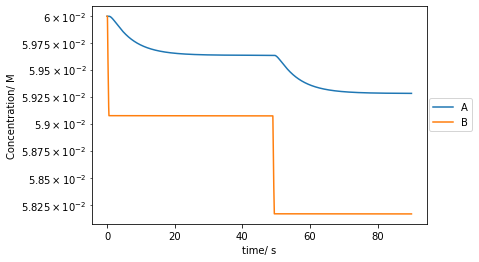

In [ ]:
plt.plot(t[::10000],As[::10000],label='A')
plt.plot(t[::10000],Bs[::10000],label='B')
plt.yscale('log')
plt.xlabel('time/ s')
plt.ylabel('Concentration/ M')
plt.legend(bbox_to_anchor =(1.15, 0.6))
plt.show()

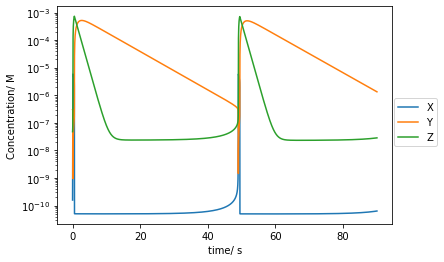

In [ ]:
plt.plot(t[::10000],Xs[::10000],label='X')
plt.plot(t[::10000],Ys[::10000],label='Y')
plt.plot(t[::10000],Zs[::10000],label='Z')
plt.yscale('log')
plt.xlabel('time/ s')
plt.ylabel('Concentration/ M')
plt.legend(bbox_to_anchor =(1.15, 0.6))
plt.show()

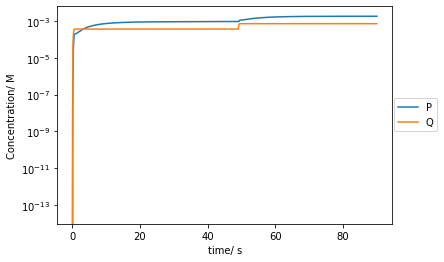

In [ ]:
plt.plot(t[::10000],Ps[::10000],label='P')
plt.plot(t[::10000],Qs[::10000],label='Q')
plt.yscale('log')
plt.xlabel('time/ s')
plt.ylabel('Concentration/ M')
plt.legend(bbox_to_anchor =(1.15, 0.6))
plt.show()

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()